В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [139]:
import pandas as pd
import numpy as np
from process_bank_churn import preprocess_data, preprocess_new_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import matplotlib
import os
%matplotlib inline


In [70]:
# 0
raw_df = pd.read_csv('../data/train.csv')
data = preprocess_data(raw_df)

X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']
imputer = data['imputer']
encoder = data['encoder']
numeric_cols = data['numeric_cols']
categorical_cols = data['categorical_cols'] 

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [71]:
# 1
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)
train_pred_knn = knn.predict(X_train)
val_pred_knn = knn.predict(X_val)

In [72]:
def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

  # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  '''# Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()
  '''

compute_auroc_and_build_roc(knn, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(knn, X_val, val_targets, 'Validation')


AUROC for Training: 0.81
AUROC for Validation: 0.55


_1. Присутнє перенавчання_

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [73]:
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': array([ 1, 2..., 22, 23, 24])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,np.int64(22)


In [74]:
knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)
#train_pred_knn_grid = knn_best.predict(X_train)
#val_pred_knn_grid = knn_best.predict(X_val)

compute_auroc_and_build_roc(knn_best, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(knn_best, X_val, val_targets, 'Validation')

{'n_neighbors': np.int64(22)} 0.7942222222222222
AUROC for Training: 0.69
AUROC for Validation: 0.59


_2. Перенавчання стало значно меньше. Також трохи підвищився показник валідаційної вибірки. Але в порівнянні з деревом рішень показник таки значно нижчий - там на валідації показник був до 0,92._ 

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [125]:
# 3
tree = DecisionTreeClassifier(random_state=42)

In [126]:
params_tree_depth = {'max_depth': np.arange(1, 21, 2)}
tree_gs_depth = GridSearchCV(tree, params_tree_depth, scoring='roc_auc', cv=3)

In [129]:
%%time
tree_gs_depth.fit(X_train, train_targets)

CPU times: total: 1 s
Wall time: 998 ms


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': array([ 1, 3..., 15, 17, 19])}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
dt_best = tree_gs_depth.best_estimator_
print(dt_best)

DecisionTreeClassifier(max_depth=np.int64(5), random_state=42)


In [131]:
compute_auroc_and_build_roc(dt_best, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(dt_best, X_val, val_targets, 'Validation')

AUROC for Training: 0.93
AUROC for Validation: 0.92


In [132]:
params_tree_leaf = {'max_leaf_nodes': np.arange(2, 11, 1)}
tree_gs_leaf = GridSearchCV(tree, params_tree_leaf, scoring='roc_auc', cv=3)

In [133]:
%%time
tree_gs_leaf.fit(X_train, train_targets)

CPU times: total: 484 ms
Wall time: 487 ms


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_leaf_nodes': array([ 2, 3..., 8, 9, 10])}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [134]:
dt_best = tree_gs_leaf.best_estimator_
print(dt_best)

DecisionTreeClassifier(max_leaf_nodes=np.int64(10), random_state=42)


In [135]:
compute_auroc_and_build_roc(dt_best, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(dt_best, X_val, val_targets, 'Validation')

AUROC for Training: 0.90
AUROC for Validation: 0.90


_3. Модель с глибиною дерева 5 значно краще на тренувальних та валідаційних даних - 0,93 / 0,92 відповідно. Модель з максимальною кількістю кінцевого листя трохи гірше - 0,90 / 0,90_ 

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [141]:
tree = DecisionTreeClassifier(random_state=42)

In [142]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}
tree_rs = RandomizedSearchCV(tree, params_dt, scoring='roc_auc', random_state=56, cv=3)

In [143]:
%%time
tree_rs.fit(X_train, train_targets)

CPU times: total: 328 ms
Wall time: 2.09 s


,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': array([ 1, 2... 18, 19]), 'max_features': [None, 'sqrt', ...], 'max_leaf_nodes': array([ 2, 3...8, 19]), ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,56
,error_score,nan


In [144]:
dt_random_search_best = tree_rs.best_estimator_
print(dt_random_search_best)

DecisionTreeClassifier(max_depth=np.int64(8), max_leaf_nodes=np.int64(15),
                       min_samples_leaf=8, min_samples_split=20,
                       random_state=42)


In [145]:
compute_auroc_and_build_roc(dt_random_search_best, X_train, train_targets, 'Training')
compute_auroc_and_build_roc(dt_random_search_best, X_val, val_targets, 'Validation')

AUROC for Training: 0.92
AUROC for Validation: 0.91


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

_4. Значення AUROC як в моделі з max_leaf_nodes. Але в мене на тестовом наборе намного гірше значення виходять з усіма попередніми параметрами. Тому я спробую цей набір гіперпараметрів моделі, який підібраний RS_

In [152]:
raw_test = pd.read_csv('../data/test.csv')

# 5.3
data_new = preprocess_new_data(raw_test)
X_test = data_new['X_test']

X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
encoded_cols_test = list(encoder.get_feature_names_out(categorical_cols))
X_test[encoded_cols_test] = encoder.transform(X_test[categorical_cols])
X_test = X_test[numeric_cols + encoded_cols_test]

# 5.4
X_test['Exited'] = dt_random_search_best.predict(X_test)
X_test.head(10)

,id,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_codes,Geography_France,Geography_Germany,Geography_Spain,Exited
0,15000.0,584.0,1.0,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,1.0,0.0,1.0,0.0,0.0
1,15001.0,551.0,1.0,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.0,1.0,0.0,0.0,0.0
2,15002.0,706.0,1.0,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.0,1.0,0.0,0.0,0.0
3,15003.0,717.0,1.0,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0,0.0,0.0,1.0,1.0
4,15004.0,592.0,1.0,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0,0.0,0.0,1.0,0.0
5,15005.0,611.0,1.0,36.0,7.0,61811.23,1.0,1.0,0.0,145796.49,1.0,1.0,0.0,0.0,0.0
6,15006.0,684.0,0.0,36.0,0.0,0.00,2.0,1.0,0.0,161671.15,0.0,1.0,0.0,0.0,0.0
7,15007.0,588.0,1.0,39.0,4.0,0.00,2.0,0.0,0.0,57862.88,0.0,1.0,0.0,0.0,0.0
8,15008.0,612.0,1.0,27.0,3.0,155413.06,2.0,1.0,0.0,140166.95,1.0,0.0,1.0,0.0,0.0
9,15009.0,736.0,0.0,32.0,8.0,0.00,2.0,1.0,0.0,75969.19,0.0,1.0,0.0,0.0,0.0


In [153]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['Exited'] = sample_submission['id'].map(X_test.set_index('id')['Exited'])
sample_submission.head(10)

,id,Exited
0,15000,0.0
1,15001,0.0
2,15002,0.0
3,15003,1.0
4,15004,0.0
5,15005,0.0
6,15006,0.0
7,15007,0.0
8,15008,0.0
9,15009,0.0


In [154]:
sample_submission.to_csv('../data/submission.csv', index=False)

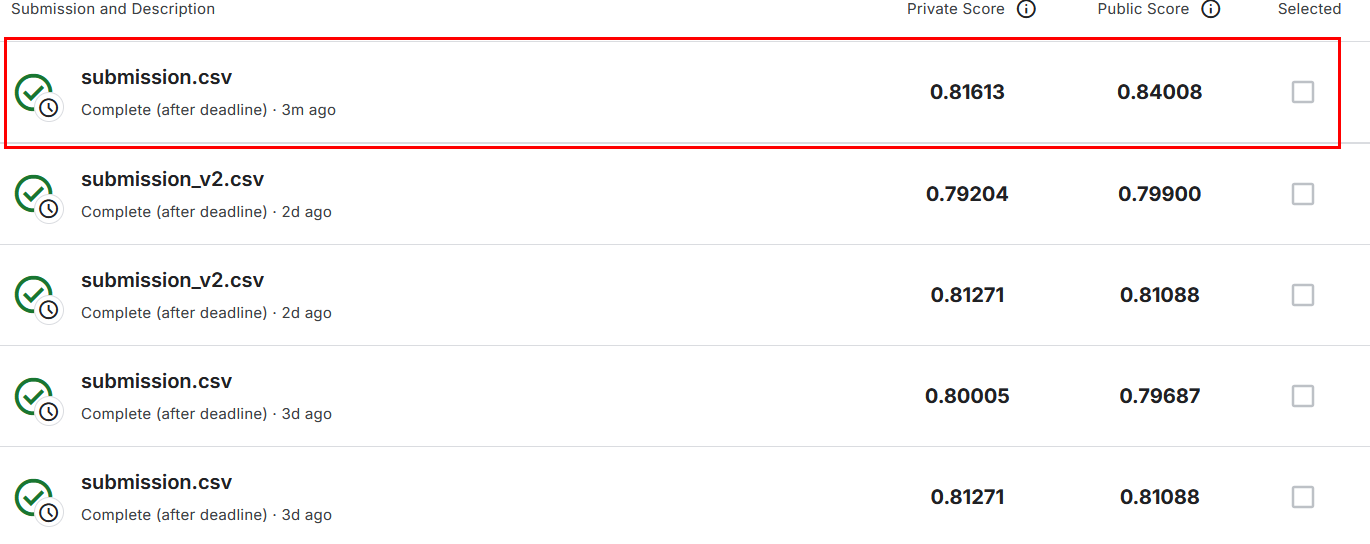

_Трохи ліпше, ніж просто глибина або макс кількість листя, але не дуже сильно_